### Train

In [43]:
import json
import matplotlib.pyplot as plt

# Load training log JSON file
training_log_path = "/raid/decaro/TimeSeriesForecastingFoundationModels/chronos_output/chronos-bolt-tiny/run-0/training_log.json"
with open(training_log_path, "r") as f:
    training_logs = json.load(f)

In [44]:
summary = training_logs[-2]
training_logs = training_logs[:-2]

In [45]:
# Pretty-print training summary
print("=== Final Training Summary ===")
print(f"Total training time:           {summary['train_runtime']:.2f} seconds")
print(f"Samples per second:            {summary['train_samples_per_second']:.2f}")
print(f"Steps per second:              {summary['train_steps_per_second']:.3f}")
print(f"Total FLOPs:                   {summary['total_flos']:.2e}")
print(f"Final training loss:           {summary['train_loss']:.4f}")

# Find best model (based on minimum loss)
best_entry = min(training_logs, key=lambda x: x["loss"])
best_epoch = best_entry["epoch"]
best_loss = best_entry["loss"]

print("=== Best Model During Training ===")
print(f"Epoch:                         {best_epoch}")
print(f"Step:                          {int(best_epoch*200_000)}")
print(f"Loss:                          {best_loss:.4f}")

=== Final Training Summary ===
Total training time:           44768.40 seconds
Samples per second:            285.92
Steps per second:              4.467
Total FLOPs:                   2.89e+17
Final training loss:           2.9882
=== Best Model During Training ===
Epoch:                         0.975
Step:                          195000
Loss:                          2.8259


In [46]:
# Extract metrics from the log
epochs = [entry["epoch"] for entry in training_logs]
steps = [entry["epoch"]*200_000 for entry in training_logs]
losses = [entry["loss"] for entry in training_logs]
grad_norms = [entry["grad_norm"] for entry in training_logs]
learning_rates = [entry["learning_rate"] for entry in training_logs]

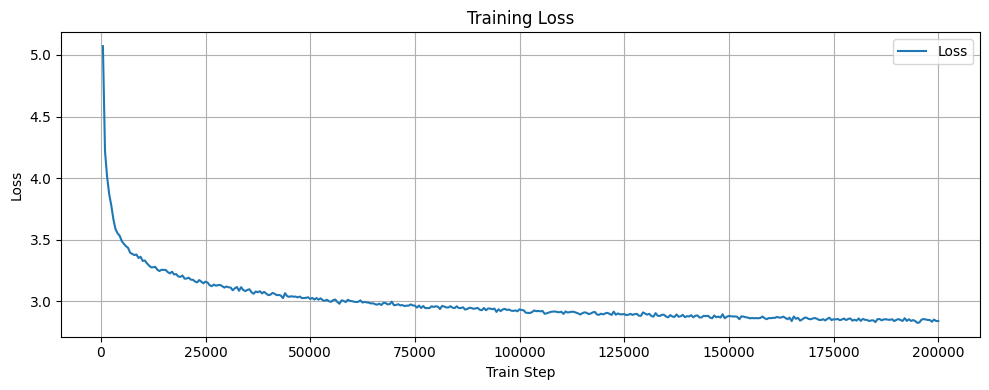

In [47]:
# Plot: Loss vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, losses, label="Loss", color="tab:blue")
plt.xlabel("Train Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

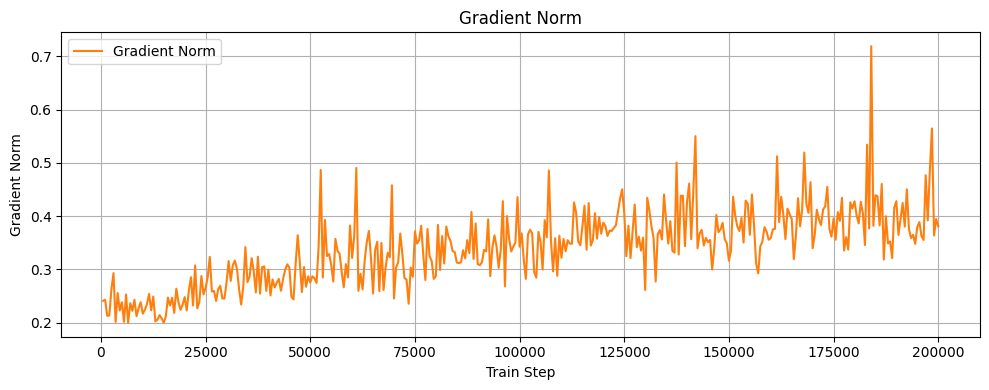

In [48]:
# Plot: Gradient Norm vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, grad_norms, label="Gradient Norm", color="tab:orange")
plt.xlabel("Train Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

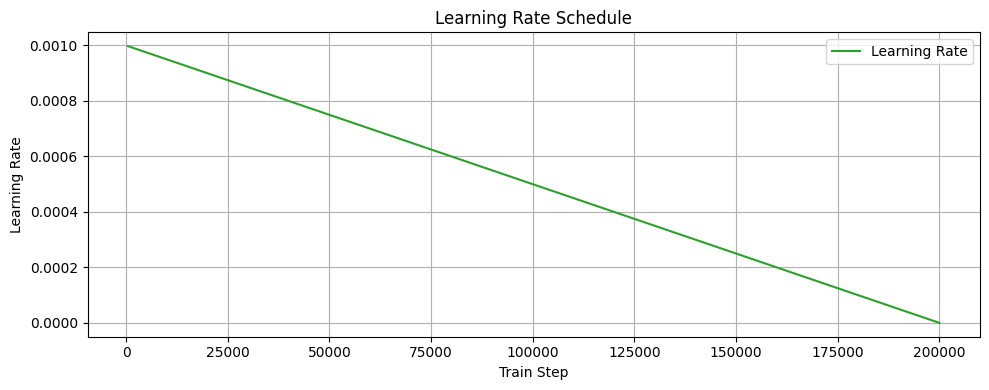

In [49]:
# Plot: Learning Rate vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, learning_rates, label="Learning Rate", color="tab:green")
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Test

In [59]:
import pandas as pd

result_path = "results/test/chronos_bolt_tiny_test_results.csv"

In [60]:
df = pd.read_csv(result_path)
df = df[["dataset", "domain", "num_variates", "model", "train_step",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
df = df.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
df = df.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})
df = df.rename(columns={"train_step": "train step"})

In [61]:
df.head()

,dataset,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate/short,Econ/Fin,1,chronos-bolt-tiny,40000,19.710698,0.057874
1,exchange_rate/medium,Econ/Fin,1,chronos-bolt-tiny,40000,19.905602,0.061386
2,exchange_rate/long,Econ/Fin,1,chronos-bolt-tiny,40000,19.700314,0.059462
3,ercot/short,Energy,1,chronos-bolt-tiny,40000,2.660235,0.166553
4,ercot/medium,Energy,1,chronos-bolt-tiny,40000,2.652010,0.166834


In [62]:
def parse_dataset_string(s):
    parts = s.split('/')
    if len(parts) == 2:
        dataset = parts[0]
        freq = None
        term = parts[1]
    elif len(parts) == 3:
        dataset, freq, term = parts
    else:
        raise ValueError(f"Unexpected dataset format: {s}")
    return pd.Series([dataset, freq, term])

# Apply the parsing
df[['dataset_name', 'freq', 'term']] = df['dataset'].apply(parse_dataset_string)

# Manually fill missing frequencies
freq_map = {
    'exchange_rate': 'D',
    'ercot': 'H',
    'dominick': 'W'
}

df['freq'] = df.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
df.drop(columns='dataset', inplace=True)

df = df.rename(columns={"dataset_name": "dataset"})
df = df[["dataset", "freq", "term", "domain", "num_variates", "model", "train step",
    "MASE", "Qloss"]]


In [63]:
df.head()

,dataset,freq,term,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate,D,short,Econ/Fin,1,chronos-bolt-tiny,40000,19.710698,0.057874
1,exchange_rate,D,medium,Econ/Fin,1,chronos-bolt-tiny,40000,19.905602,0.061386
2,exchange_rate,D,long,Econ/Fin,1,chronos-bolt-tiny,40000,19.700314,0.059462
3,ercot,H,short,Energy,1,chronos-bolt-tiny,40000,2.660235,0.166553
4,ercot,H,medium,Energy,1,chronos-bolt-tiny,40000,2.652010,0.166834


In [66]:
grouped_domain = df.groupby(['train step', 'domain'], as_index=False).mean(numeric_only=True)
grouped_domain = grouped_domain.sort_values(by=['train step', 'domain'])
grouped_domain


,train step,domain,num_variates,MASE,Qloss
0,40000,Econ/Fin,1.0,19.772205,0.059574
1,40000,Energy,1.0,2.708638,0.169234
2,40000,Sales,1.0,3.046657,0.700488
3,50000,Econ/Fin,1.0,19.797709,0.058778
4,50000,Energy,1.0,2.703942,0.171032
5,50000,Sales,1.0,3.077888,0.706558
6,60000,Econ/Fin,1.0,19.500681,0.059709
7,60000,Energy,1.0,2.687820,0.168392
8,60000,Sales,1.0,3.051201,0.699122
9,70000,Econ/Fin,1.0,19.666250,0.058857


In [67]:
grouped_freq = df.groupby(['train step', 'freq'], as_index=False).mean(numeric_only=True)
grouped_freq = grouped_freq.sort_values(by=['train step', 'freq'])
grouped_freq

,train step,freq,num_variates,MASE,Qloss
0,40000,10S,1.0,7.844158,0.115193
1,40000,10T,1.0,1.743321,0.770999
2,40000,5T,1.0,2.143697,0.847770
3,40000,D,1.0,12.552748,0.165712
4,40000,H,1.0,2.337163,0.702451
5,40000,W,1.0,2.728331,0.923747
6,50000,10S,1.0,7.913612,0.114887
7,50000,10T,1.0,1.760578,0.784948
8,50000,5T,1.0,2.137569,0.848736
9,50000,D,1.0,12.562270,0.165773


In [68]:
grouped_term = df.groupby(['train step', 'term'], as_index=False).mean(numeric_only=True)
grouped_term = grouped_term.sort_values(by=['train step', 'term'])
grouped_term

,train step,term,num_variates,MASE,Qloss
0,40000,long,1.0,4.373189,0.624608
1,40000,medium,1.0,4.493444,0.612808
2,40000,short,1.0,3.774960,0.623253
3,50000,long,1.0,4.425639,0.626518
4,50000,medium,1.0,4.497309,0.615329
5,50000,short,1.0,3.803688,0.633034
6,60000,long,1.0,4.392582,0.622186
7,60000,medium,1.0,4.486784,0.611906
8,60000,short,1.0,3.726632,0.622653
9,70000,long,1.0,5.191125,0.479829
